In [ ]:
# Ran this code on Kaggle Notebook. Uploaded the dataset available on Kaggle to the notebook and used it to run the code.
# Dataset Link: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images 

In [6]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout
import warnings

warnings.filterwarnings('ignore')

In [7]:
import tensorflow as tf

# to check TensorFlow version
print("TensorFlow version:", tf.__version__)

# to find the name of GPU device
gpu_device_name = tf.test.gpu_device_name()
print("GPU device name: ", gpu_device_name)

TensorFlow version: 2.15.0
GPU device name:  /device:GPU:0


In [9]:
dataset_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

In [10]:
def data_loader(dataset_dir):
    image_file_paths = []
    classes = []
    folders = os.listdir(dataset_dir)

    for folder in folders:
        folder_path = os.path.join(dataset_dir, folder)
        image_file_list = os.listdir(folder_path)
        for image_file in image_file_list:
            path = os.path.join(folder_path, image_file)
            
            image_file_paths.append(path)
            classes.append(folder)

    df = pd.DataFrame({'image_file_path': image_file_paths, 'class': classes})
    
    return df

df = data_loader(dataset_dir)
df

,image_file_path,class
0,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
1,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
2,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
3,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
4,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_aca
...,...,...
14995,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_n
14996,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_n
14997,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_n
14998,/kaggle/input/lung-and-colon-cancer-histopatho...,lung_n


In [11]:
class_counts = df['class'].value_counts()
print(class_counts)

class
lung_aca    5000
lung_scc    5000
lung_n      5000
Name: count, dtype: int64


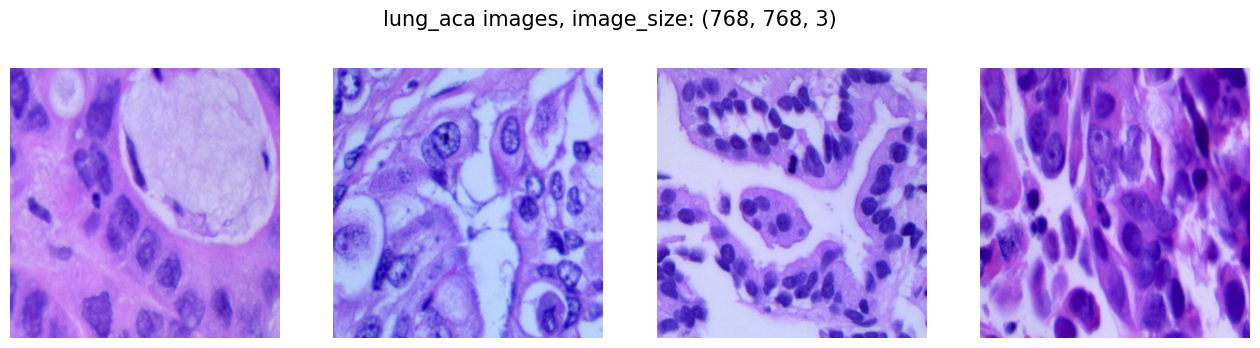

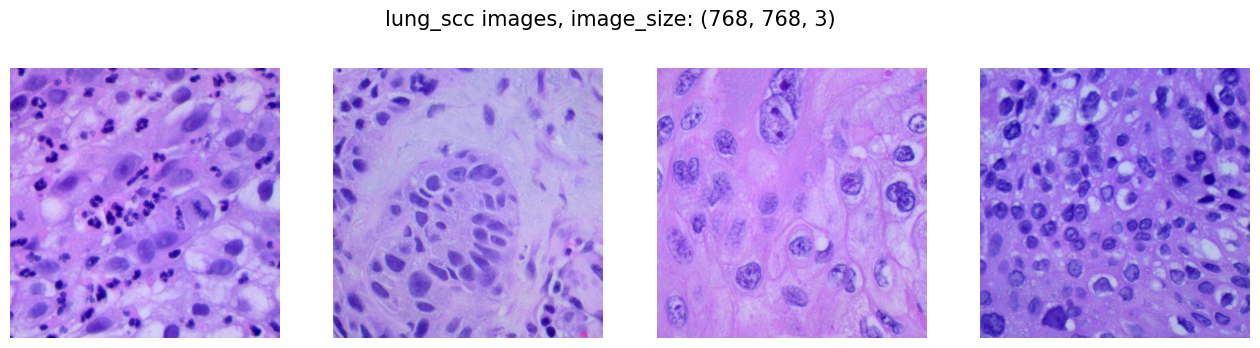

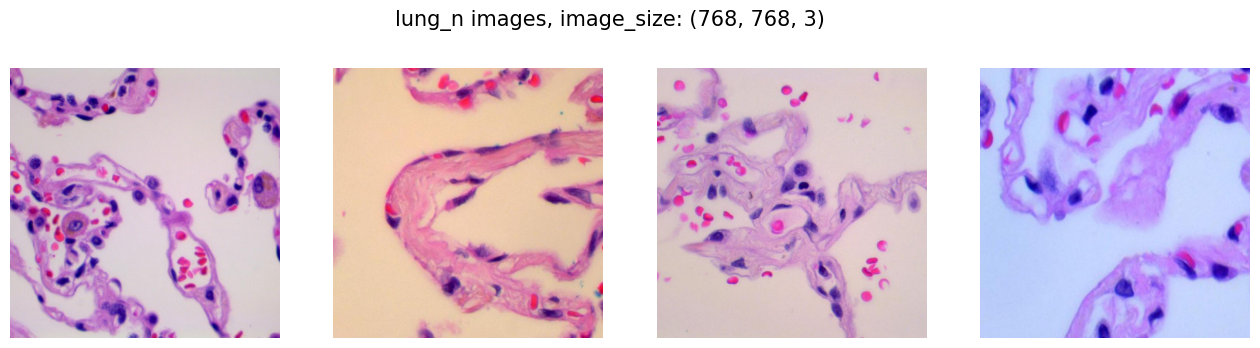

In [12]:
for class_name in class_counts.index: 
    class_image_dir = f'{dataset_dir}/{class_name}'
    class_images = os.listdir(class_image_dir) 
  
    fig, ax = plt.subplots(1, 4, figsize = (16, 4)) 
  
    k = 5
    for i in range(4):  
        img = cv2.imread(f'{dataset_dir}/{class_name}/{class_images[k]}')  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img) 
        ax[i].axis('off') 
        k += 2
        
    fig.suptitle(f'{class_name} images, image_size: {img.shape}',  
                 fontsize = 15) 
    plt.show()

# **Data Prepocessing**

In [13]:
# Train-Validation-Test Split
train_df, validation_test_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state=11)

validation_df, test_df = train_test_split(validation_test_df, train_size = 0.5, shuffle = True, random_state=11)

In [14]:
train_df.shape, validation_df.shape, test_df.shape

((12000, 2), (1500, 2), (1500, 2))

In [15]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col= 'image_file_path', y_col='class', target_size=(IMAGE_SIZE,IMAGE_SIZE), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(validation_df, x_col='image_file_path', y_col='class', target_size=(IMAGE_SIZE,IMAGE_SIZE), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle=True, batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_dataframe(test_df, x_col='image_file_path', y_col='class', target_size=(IMAGE_SIZE,IMAGE_SIZE), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [16]:
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

Class indices: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


In [25]:
# ResNet50 Model Construction

resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

model_1 = Sequential()
model_1.add(resnet)
model_1.add(Flatten())
model_1.add(Dropout(0.4))

# Adding Custom Dense Layers
model_1.add(Dense(128, activation="relu"))
model_1.add(Dense(64, activation="relu"))
model_1.add(Dense(16, activation="relu"))
model_1.add(Dense(3, activation="sigmoid"))

In [27]:
model_1.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [28]:
history_1 = model_1.fit(train_generator, epochs = 8, validation_data = validation_generator)

Epoch 1/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 198s 730ms/step - accuracy: 0.5836 - loss: 0.8651 - val_accuracy: 0.5400 - val_loss: 1.0676
Epoch 2/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 558ms/step - accuracy: 0.6075 - loss: 0.1161 - val_accuracy: 0.3167 - val_loss: 7.4970
Epoch 3/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 558ms/step - accuracy: 0.5946 - loss: 0.0770 - val_accuracy: 0.3773 - val_loss: 1.4808
Epoch 4/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 559ms/step - accuracy: 0.5537 - loss: 0.0602 - val_accuracy: 0.3487 - val_loss: 9.6395
Epoch 5/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 554ms/step - accuracy: 0.5761 - loss: 0.0537 - val_accuracy: 0.3153 - val_loss: 2.0801
Epoch 6/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 557ms/step - accuracy: 0.6093 - loss: 0.0595 - val_accuracy: 0.6553 - val_loss: 0.1385
Epoch 7/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 556ms/step - accuracy: 0.5622 - loss: 0.0287 - val_accuracy: 0.6087 - val_loss: 0.1684
Epoch 8/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 558ms/step - accuracy: 0.5639 - loss: 0

In [31]:
predictions = model_1.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1)

y_true = test_generator.classes

24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 846ms/step


In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.99      0.69       479
           1       0.98      0.74      0.85       494
           2       1.00      0.43      0.60       527

    accuracy                           0.71      1500
   macro avg       0.84      0.72      0.71      1500
weighted avg       0.84      0.71      0.71      1500



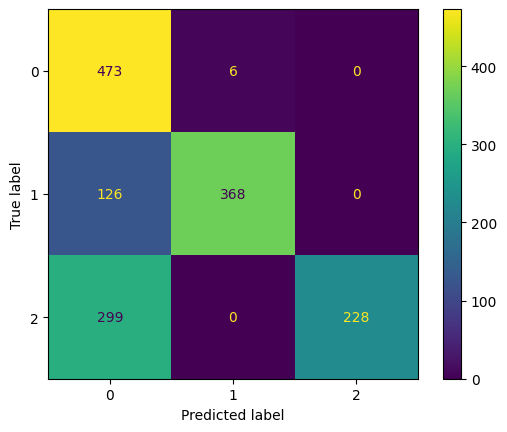

In [34]:
c_matrix = confusion_matrix(y_true, y_pred)

confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = [0, 1, 2])

confusion_matrix_display.plot()
plt.show()